<a href="https://colab.research.google.com/github/emukans/en-lv-translator/blob/master/xlm_r_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using all XML-R token embeddings for training model for translation task and using MS-COCO dataset

The notebook is working on TensorFlow v1. By default it's using a different `gast` package version, what will raise warnings during training.


In [0]:
%tensorflow_version 1.x
!pip install 'gast==0.2.2'

TensorFlow 1.x selected.
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=db603dcdea4cc8368f6531e91111e1693028cb100094cce1c067ce03d46dbe28
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


Import necessary libraries

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import collections

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

import pandas as pd
from datetime import datetime

Using TensorFlow backend.


Eager execution will help to evaluate operations immediately, without bulding graphs.

In [0]:
tfe = tf.contrib.eager
tfe.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



##Prepare MS-COCO dataset

###Mount Google Drive

Google Drive is used for storing training checkpoints and restoring training sessions.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


###Download data

Prepare MS-COCO annotations are stored in Google Storage.

The data is publicly available and archived. There are 2 files:

* annotations.en - english sentences (one line - one sentence)
* annotations.lv - latvian sentences (one line - one sentence)



In [0]:
import zipfile

!gsutil -m cp gs://translator-lv-en/annotations.zip annotations.zip

with zipfile.ZipFile('annotations.zip', 'r') as zip_ref:
    zip_ref.extractall()

Copying gs://translator-lv-en/annotations.zip...
\ [1/1 files][ 17.1 MiB/ 17.1 MiB] 100% Done                                    
Operation completed over 1 objects/17.1 MiB.                                     


###Preprocess data

In [0]:
raw_en_annotations = []
annotation_en_file = 'annotations/annotations.en'
with open(annotation_en_file, 'r') as f:
    raw_en_annotations = f.readlines()

def prepare_caption(caption: str):
  return f'<start> {caption.strip()} <end>'

skip_index_list = []
for i in range(len(raw_en_annotations[:5000])):
  if len(raw_en_annotations[i].split()) > 15:
    skip_index_list.append(i)

raw_en_annotations = [sentence for i, sentence in enumerate(raw_en_annotations[:5000]) if i not in skip_index_list]
prepared_en_caption_list = shuffle(raw_en_annotations[:1000], random_state=1)
prepared_en_caption_list = [prepare_caption(caption) for caption in prepared_en_caption_list]

raw_lv_annotations = []
annotation_lv_file = 'annotations/annotations.lv'
with open(annotation_lv_file, 'r') as f:
    raw_lv_annotations = f.readlines()

raw_lv_annotations = [sentence for i, sentence in enumerate(raw_lv_annotations[:5000]) if i not in skip_index_list]
prepared_lv_caption_list = shuffle(raw_lv_annotations[:1000], random_state=1)
prepared_lv_caption_list = [prepare_caption(caption) for caption in prepared_lv_caption_list]

In [0]:
len(prepared_lv_caption_list)

1000

##Prepare XLM-R pretrained model

XLM-R model is trained by Facebook AI and is publicly available. The model can be downloaded from Torch Hub.

In [0]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 3.5MB/s 


In [0]:
import torch
xlmr = torch.hub.load('pytorch/fairseq', 'xlmr.large')
xlmr.eval()

Downloading: "https://github.com/pytorch/fairseq/archive/master.zip" to /root/.cache/torch/hub/master.zip


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
running build_ext
cythoning fairseq/data/data_utils_fast.pyx to fairseq/data/data_utils_fast.cpp
cythoning fairseq/data/token_block_utils_fast.pyx to fairseq/data/token_block_utils_fast.cpp
building 'fairseq.libbleu' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/fairseq
creating build/temp.linux-x86_64-3.6/fairseq/clib
creating build/temp.linux-x86_64-3.6/fairseq/clib/libbleu
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c fairseq/clib/libbleu/libbleu.cpp -o build/temp.linux-x86_64-3.6/fairseq/clib/libbleu/libbleu.o -std=c++11 -O3 -DTORCH_API_INCLUDE_EXTENSION_H -DTORCH_EXTENSION_NAME=libbleu -D_GLIBCXX_USE_CXX11_ABI=0
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security

100%|██████████| 1028340964/1028340964 [00:29<00:00, 35008354.98B/s]


RobertaHubInterface(
  (model): RobertaModel(
    (decoder): RobertaEncoder(
      (sentence_encoder): TransformerSentenceEncoder(
        (embed_tokens): Embedding(250002, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 1024, padding_idx=1)
        (layers): ModuleList(
          (0): TransformerSentenceEncoderLayer(
            (self_attn): MultiheadAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (final_layer_norm): 

To get XLM-R embeddings, need to:

* Encode every sentence. After encoding the sentece will be tokenized and replaced with token ID;
* Then tokens can be transformed to embeddings.

In [0]:
word_embeddings = [xlmr.extract_features(xlmr.encode(sentence))[0].tolist() for sentence in prepared_en_caption_list]

Limit sentence length to 32 tokens

In [1]:
text = [word for word in word_embeddings if len(word) < 33]

NameError: ignored

Extend every sentence to shape (32, 1024)

In [0]:
expanded_embeddings  = []

for word in text:
  for _ in range(32 - len(word)):
    word.append(np.zeros(1024))
  expanded_embeddings.append(word)

In [0]:
for word in expanded_embeddings:
  assert len(word) == 32

assert len(expanded_embeddings) == 1000 

#Prepare translation model

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# Choose the top 1000 words from the vocabulary
top_k = 1000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(prepared_lv_caption_list)
train_seqs = tokenizer.texts_to_sequences(prepared_lv_caption_list)

In [0]:
len(tokenizer.word_counts)

2176

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(prepared_lv_caption_list)

In [0]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [0]:
# Create training and validation sets using an 80-20 split
word_train, word_val, cap_train, cap_val = train_test_split(expanded_embeddings,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [0]:
len(word_train), len(cap_train), len(word_val), len(cap_val)

(800, 800, 200, 200)

## Create a tf.data dataset for training


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(word_train) // BATCH_SIZE
# Shape of the vector extracted from XML-R is (32, 1024)
# These two variables represent that vector shape
features_shape = 1024

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((word_train, cap_train))

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

The LSTM model consists of an encoder and a decoder.

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights
    # return x, state

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [0]:
checkpoint_path = "./gdrive/My Drive/bert_translate/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [0]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [0]:
def evaluate_annotation(img_tensor):
  img_tensor = tf.expand_dims(img_tensor, 0)
  features = encoder(img_tensor)
  hidden = decoder.reset_state(batch_size=1)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []
  for i in range(max_length):
    predictions, hidden, _ = decoder(dec_input, features, hidden)
    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

    result.append(tokenizer.index_word[predicted_id])

    if tokenizer.index_word[predicted_id] == '<end>':
        return result
    dec_input = tf.expand_dims([predicted_id], 0)
  return result

In [0]:
EPOCHS = 100

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    last_tensor = None
    last_target = None

    for (batch, (img_tensor, target)) in enumerate(dataset):
        last_tensor = img_tensor
        last_target = target
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    # if epoch % 10 == 0:
    print('Real:')
    print(' '.join([tokenizer.index_word[predicted_id.numpy()] for predicted_id in last_target[-1]]))
    print('Predicted:')
    print(' '.join(evaluate_annotation(last_tensor[-1])))
    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Batch 0 Loss 3.6480
Real:
<start> balta tualete atrodas uz flīžu grīdas <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted:
<end>
Epoch 1 Loss 3.181271
Time taken for 1 epoch 74.72594738006592 sec

Epoch 2 Batch 0 Loss 2.6929
Real:
<start> balta tualete atrodas uz flīžu grīdas <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted:
ābolu skatās cepa melnbalta tualeti <unk> stāvvietas piebraucamā izlietne un autobusā <unk> akmens <end>
Epoch 2 Loss 2.862262
Time taken for 1 epoch 3.563305139541626 sec

Epoch 3 Batch 0 Loss 2.6224
Real:
<start> balta tualete atrodas uz flīžu grīdas <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Predicted:
<unk> un debesīs <unk> baltām istabā ar gatavo <unk> zona papīriem <end>
Epoch 3 Loss 2.809894
Time taken for 1 epoch 3.726828098297119 sec

Epoch 4 Batch 0 Loss 2.5552
Real:
<start> balta tualete atrodas uz flīžu grīdas <en

In [0]:
np.save('gdrive/My Drive/bert_translate/loss_plot', loss_plot)

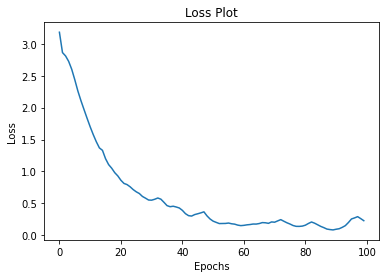

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def evaluate(word):
    hidden = decoder.reset_state(batch_size=1)

    word_tensor_val = tf.expand_dims(word, 0)
    features = encoder(word_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)
    return result

In [0]:
# captions on the validation set
rid = np.random.randint(0, len(word_val))
word = word_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

result = evaluate(word)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))


Real Caption: <start> seši dažādi cilvēki <unk> un <unk> gatavo dārzeņus <end>
Prediction Caption: <unk> <unk> <unk> ar <unk> ar <unk> ar <unk> ar <unk> ar <unk> ar <unk> ar
Prediction Caption: [[-0.013798128813505173, 0.07536707818508148, 0.11847737431526184, -0.06101560220122337, -0.03987659886479378, 0.07873807102441788, 0.04575227200984955, 0.012480388395488262, 0.04683467000722885, 0.04461590200662613, -0.008121369406580925, -0.01833830215036869, -0.032200608402490616, -0.1963459551334381, 0.12269873172044754, -0.05994042754173279, 0.060964666306972504, 0.11032509803771973, -0.11727335304021835, 0.04546168074011803, -0.0246573556214571, -0.24210673570632935, -0.11630943417549133, 0.19345538318157196, 0.028938159346580505, 0.04038022831082344, -0.1780340075492859, 0.044897086918354034, 0.051678311079740524, -0.213050976395607, -0.21695402264595032, -0.08883296698331833, -0.03872116655111313, 0.07868476957082748, -0.03299790620803833, -0.0038817094173282385, 0.048520997166633606, -0

In [0]:
def translate(en_text):
  embedding = xlmr.extract_features(xlmr.encode(en_text))[0].tolist()

  assert len(embedding) <= 32
  for _ in range(32 - len(embedding)):
    embedding.append(np.zeros(1024))

  return ' '.join(evaluate(embedding))

In [0]:
rid = np.random.randint(0, len(prepared_en_caption_list))
en_text = prepared_en_caption_list[rid]
lv_text = translate(en_text)

print ('EN:', en_text.replace('<start> ', '').replace(' <end>', '').lower())
print ('LV:', lv_text.replace('<start> ', '').replace(' <end>', ''))

EN: a shop is open
LV: šī ir ļoti <unk> <unk> tv
